# Based on Hugging Face Transformers

https://github.com/huggingface/transformers

In [1]:
#!pip install transformers
#!pip install keras
#!pip install tensorflow==1.15

# Preprocessing

In [2]:
import transformers as ppb
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
import torch
import math

Using TensorFlow backend.


In [3]:
# For DistilBERT:
#model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-cased')

## Want BERT instead of distilBERT? Uncomment the following line:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-cased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [4]:
df = pd.read_csv("../datasets/NER/train.tsv", sep="\t", header=None)
df = df.replace(np.nan, '', regex=True)
test_df = pd.read_csv("../datasets/NER/test.tsv", sep="\t", header=None)
test_df = test_df.replace(np.nan, '', regex=True)

In [5]:
# Truncate long sentences to 128 tokens
X = df[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=128)))
y = np.array(df[1])
y = ['missing' if x is np.nan else x for x in y]
del df

X_test = test_df[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=128)))
y_test = np.array(test_df[1])
y_test = ['missing' if x is np.nan else x for x in y_test]
del test_df

In [6]:
# One hot Encoding of y
encoder = LabelEncoder()
encoder.fit(y)

y = encoder.transform(y)
y = to_categorical(y)

# One hot Encoding of y test
y_oh = encoder.transform(y_test)
y_oh = to_categorical(y_oh)

In [7]:
def GetEmbeddings(tokenizedBatch):
    max_len = 0
    for i in tokenizedBatch.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenizedBatch.values])
    
    attention_mask = np.where(padded != 0, 1, 0)
    
    input_ids = torch.tensor(padded).to(torch.long)  
    attention_mask = torch.tensor(attention_mask)

    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    
    features = last_hidden_states[0][:,0,:].numpy()
    return features

In [8]:
BATCH_SIZE = 5000
all_embeddings = []
all_embeddings_test = []

# Process Training Set Embeddings
batches = math.ceil(X.shape[0] / BATCH_SIZE)

for i in range(1, batches+1):
    print("Generating Embeddings for Batch:",i,"of", batches)
    batchEmbeddings = GetEmbeddings(X[(i-1)*BATCH_SIZE:i*BATCH_SIZE])
    all_embeddings.append(batchEmbeddings)

# Process Test Set Embeddings
batches = math.ceil(X_test.shape[0] / BATCH_SIZE)

for i in range(1, batches+1):
    print("Generating Test Embeddings for Batch:",i,"of", batches)
    batchEmbeddings = GetEmbeddings(X_test[(i-1)*BATCH_SIZE:i*BATCH_SIZE])
    all_embeddings_test.append(batchEmbeddings)

Generating Embeddings for Batch: 1 of 4
Generating Embeddings for Batch: 2 of 4
Generating Embeddings for Batch: 3 of 4
Generating Embeddings for Batch: 4 of 4
Generating Test Embeddings for Batch: 1 of 2
Generating Test Embeddings for Batch: 2 of 2


In [9]:
all_embeddings = np.concatenate(all_embeddings, axis=0)
all_embeddings_test = np.concatenate(all_embeddings_test, axis=0)

In [10]:
np.save('../binary/bert_NER_embeddings_twitter.npy', all_embeddings)
np.save('../binary/y_NER_twitter.npy', y)
np.save('../binary/bert_NER_embeddings_test_twitter.npy', all_embeddings_test)
np.save('../binary/y_test_NER_twitter.npy', y_oh)

# Train Model

In [11]:
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

import tensorflow as tf
import tensorflow.keras as keras 
from keras.layers import Input, Lambda, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.optimizers import adam, sgd

In [12]:
all_embeddings = np.load('../binary/bert_NER_embeddings_twitter.npy')
y = np.load('../binary/y_NER_twitter.npy')
all_embeddings_test = np.load('../binary/bert_NER_embeddings_test_twitter.npy')
y_oh = np.load('../binary/y_test_NER_twitter.npy')

In [13]:
#sgd = sgd(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
optim = adam(lr=0.0003, beta_1=0.9, beta_2=0.999, amsgrad=False)

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
def build_model(): 
    embedding = Input(shape=(768,), dtype="float")
    dense1 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(embedding)
    dense2 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense1)
    dense3 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense2)
    dense4 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense3)
    dense5 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense4)
    dense6 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense5)
    dense7 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense6)
    dense8 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense7)
    dense9 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense8)
    dense10 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense9)
    pred = Dense(4, activation='sigmoid')(dense9)
    model = Model(inputs=[embedding], outputs=pred)
    model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'], )
    return model

In [15]:
model_bert = build_model()

In [16]:
model_bert.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              769000    
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              1001000   
__________

# Change to training set

In [17]:
es = EarlyStopping(monitor='loss', patience=15)
cb_list = [es]

In [18]:
with tf.Session() as session:
    K.set_session(session)
    #tf.compat.v1.keras.backend.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model_bert.fit(all_embeddings, y, epochs=1000, batch_size=10000, 
                             validation_split = 0.001, callbacks=cb_list)
    model_bert.save_weights('../model/bert_ner_logistic_twitter/model_bert_weights.h5')

Instructions for updating:
Use tf.cast instead.
Train on 15619 samples, validate on 16 samples
Epoch 1/1000
15619/15619 [==============================] - 3s 186us/step - loss: 10.1370 - acc: 0.7936 - val_loss: 9.8023 - val_acc: 0.6250
Epoch 2/1000
15619/15619 [==============================] - 0s 13us/step - loss: 9.3882 - acc: 0.9365 - val_loss: 9.9416 - val_acc: 0.6250
Epoch 3/1000
15619/15619 [==============================] - 0s 11us/step - loss: 8.7776 - acc: 0.9365 - val_loss: 11.0300 - val_acc: 0.6250
Epoch 4/1000
15619/15619 [==============================] - 0s 10us/step - loss: 8.6819 - acc: 0.9365 - val_loss: 9.5177 - val_acc: 0.6250
Epoch 5/1000
15619/15619 [==============================] - 0s 11us/step - loss: 8.3510 - acc: 0.9365 - val_loss: 8.8557 - val_acc: 0.6250
Epoch 6/1000
15619/15619 [==============================] - 0s 12us/step - loss: 8.1887 - acc: 0.9365 - val_loss: 8.9740 - val_acc: 0.6250
Epoch 7/1000
15619/15619 [==============================] - 0s 11us/

15619/15619 [==============================] - 0s 11us/step - loss: 2.2755 - acc: 0.9365 - val_loss: 3.1613 - val_acc: 0.6250
Epoch 58/1000
15619/15619 [==============================] - 0s 10us/step - loss: 2.2259 - acc: 0.9365 - val_loss: 3.2575 - val_acc: 0.6250
Epoch 59/1000
15619/15619 [==============================] - 0s 10us/step - loss: 2.1799 - acc: 0.9365 - val_loss: 2.9710 - val_acc: 0.6250
Epoch 60/1000
15619/15619 [==============================] - 0s 10us/step - loss: 2.1330 - acc: 0.9365 - val_loss: 3.0456 - val_acc: 0.6250
Epoch 61/1000
15619/15619 [==============================] - 0s 12us/step - loss: 2.0852 - acc: 0.9365 - val_loss: 3.0539 - val_acc: 0.6250
Epoch 62/1000
15619/15619 [==============================] - 0s 12us/step - loss: 2.0411 - acc: 0.9365 - val_loss: 2.8634 - val_acc: 0.6250
Epoch 63/1000
15619/15619 [==============================] - 0s 12us/step - loss: 1.9981 - acc: 0.9365 - val_loss: 2.9409 - val_acc: 0.6250
Epoch 64/1000
15619/15619 [=======

15619/15619 [==============================] - 0s 10us/step - loss: 0.8834 - acc: 0.9385 - val_loss: 1.7478 - val_acc: 0.6250
Epoch 116/1000
15619/15619 [==============================] - 0s 10us/step - loss: 0.8773 - acc: 0.9429 - val_loss: 1.9170 - val_acc: 0.6250
Epoch 117/1000
15619/15619 [==============================] - 0s 11us/step - loss: 0.8652 - acc: 0.9421 - val_loss: 2.1015 - val_acc: 0.6250
Epoch 118/1000
15619/15619 [==============================] - 0s 10us/step - loss: 0.8583 - acc: 0.9396 - val_loss: 1.8315 - val_acc: 0.6250
Epoch 119/1000
15619/15619 [==============================] - 0s 11us/step - loss: 0.8440 - acc: 0.9437 - val_loss: 1.9570 - val_acc: 0.6250
Epoch 120/1000
15619/15619 [==============================] - 0s 10us/step - loss: 0.8340 - acc: 0.9439 - val_loss: 2.0458 - val_acc: 0.6250
Epoch 121/1000
15619/15619 [==============================] - 0s 10us/step - loss: 0.8258 - acc: 0.9412 - val_loss: 1.8250 - val_acc: 0.6250
Epoch 122/1000
15619/15619 [

15619/15619 [==============================] - 0s 10us/step - loss: 0.5495 - acc: 0.9533 - val_loss: 1.6415 - val_acc: 0.6250
Epoch 174/1000
15619/15619 [==============================] - 0s 10us/step - loss: 0.5424 - acc: 0.9545 - val_loss: 1.6889 - val_acc: 0.6250
Epoch 175/1000
15619/15619 [==============================] - 0s 11us/step - loss: 0.5361 - acc: 0.9557 - val_loss: 1.9353 - val_acc: 0.6250
Epoch 176/1000
15619/15619 [==============================] - 0s 10us/step - loss: 0.5354 - acc: 0.9547 - val_loss: 1.7161 - val_acc: 0.6250
Epoch 177/1000
15619/15619 [==============================] - 0s 10us/step - loss: 0.5309 - acc: 0.9555 - val_loss: 1.5757 - val_acc: 0.6250
Epoch 178/1000
15619/15619 [==============================] - 0s 10us/step - loss: 0.5410 - acc: 0.9527 - val_loss: 1.6856 - val_acc: 0.6250
Epoch 179/1000
15619/15619 [==============================] - 0s 10us/step - loss: 0.5255 - acc: 0.9553 - val_loss: 2.0254 - val_acc: 0.6250
Epoch 180/1000
15619/15619 [

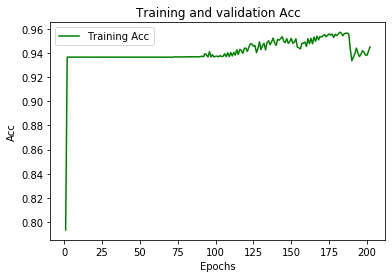

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

#acc = history.history['acc']
acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

# Predict on Test Data

In [21]:
bs = 10000
batches = math.ceil(all_embeddings_test.shape[0] / bs)

In [22]:
all_preds = []
all_probs = []
    
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    model_bert.load_weights('../model/bert_ner_logistic_twitter/model_bert_weights.h5')

    for i in range(1,batches+1):
        print("Predicting Batch",i)
        new_text_pr = all_embeddings_test[(i-1)*bs:i*bs]
        preds = model_bert.predict(new_text_pr)
        all_probs.append(preds)
        preds = encoder.inverse_transform(np.argmax(preds,axis=1))
        all_preds.append(preds)

Predicting Batch 1


In [23]:
results = np.concatenate(all_preds, axis=0)
results_probs = np.concatenate(all_probs, axis=0)

In [25]:
np.savetxt("../output/NER/bert_logistic_twitter/test_results.tsv", results_probs, delimiter="\t")

In [26]:
np.savetxt("../output/NER/bert_logistic_twitter/test_predictions.tsv", results, delimiter="\t", fmt='%s')

In [27]:
print("Accuracy: ",sum(results==y_test)/results.shape[0])

Accuracy:  0.9481509013194573
